In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

In [ ]:
ticker = 'AAPL'
start_date = '2010-01-01'
end_date = '2023-12-31'

data = yf.download(ticker, start=start_date, end=end_date)
data.to_csv('AAPL_stock_data.csv')

[*********************100%***********************]  1 of 1 completed


In [ ]:
df = pd.read_csv('AAPL_stock_data.csv', skiprows=2, header=None,
                 names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

def calculate_indicators(data):
    """Compute common technical indicators for trading analysis."""

    # Moving Averages
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()

    # Relative Strength Index (RSI)
    delta = data['Close'].diff()
    gain = delta.clip(lower=0).rolling(window=14).mean()
    loss = -delta.clip(upper=0).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # MACD and Signal Line
    ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = ema_12 - ema_26
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands (using SMA_20)
    rolling_std = data['Close'].rolling(window=20).std()
    data['Upper_Bollinger'] = data['SMA_20'] + 2 * rolling_std
    data['Lower_Bollinger'] = data['SMA_20'] - 2 * rolling_std

    return data

df = calculate_indicators(df)
df.dropna(inplace=True)

In [ ]:
# Define input features and target variable
features = ['Open', 'High', 'Low', 'Volume',
            'SMA_50', 'SMA_200', 'RSI',
            'MACD', 'Signal_Line', 'Upper_Bollinger', 'Lower_Bollinger']
target = 'Close'

X = df[features]
y = df[target]

# Normalize the data for modeling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled,
                                                    test_size=0.2,
                                                    shuffle=False)

In [ ]:
# Reshape for LSTM input: (samples, time steps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32,
               validation_data=(X_test_lstm, y_test),
               verbose=1, shuffle=False)

# Predict using LSTM model
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test)

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 8.7145e-04 - val_loss: 0.0032
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0590 - val_loss: 0.0033
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0202 - val_loss: 0.0068
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 7.1776e-04 - val_loss: 0.0020
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0058 - val_loss: 0.0039
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - val_loss: 8.1167e-04
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010 - val_loss: 8.3088e-04
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - val_loss: 7.4350e-04
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9414e-04 - val_loss: 0.0011
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.2544e-04 - val_loss: 0.0011
Epoch 12/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
# Flatten LSTM inputs back to 2D for traditional models
X_train_rf = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[2])
X_test_rf = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[2])

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train.ravel())

# Predict using Random Forest
rf_predictions = rf_model.predict(X_test_rf)
rf_predictions = scaler.inverse_transform(rf_predictions.reshape(-1, 1))

LSTM Model - MSE: 145.61, MAE: 9.03
Random Forest Model - MSE: 667.31, MAE: 19.79


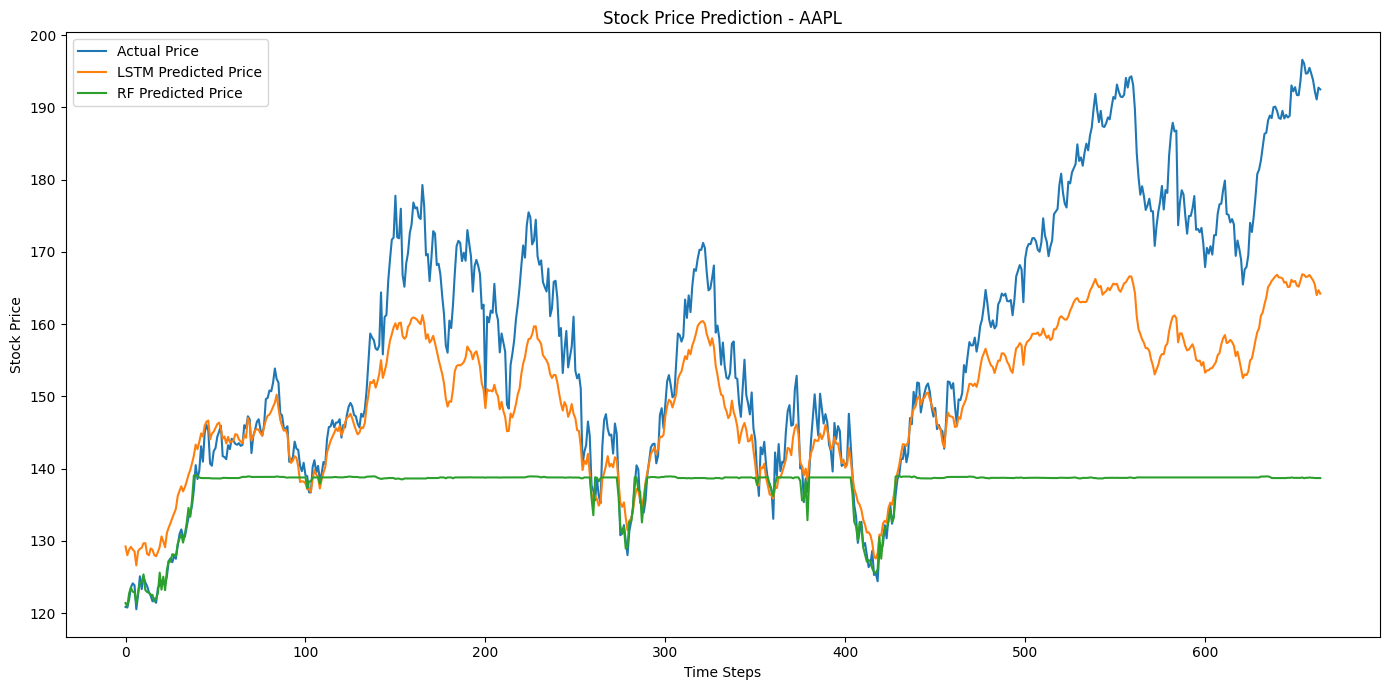

In [ ]:
# Evaluation metrics
lstm_mse = mean_squared_error(y_test_actual, lstm_predictions)
lstm_mae = mean_absolute_error(y_test_actual, lstm_predictions)

rf_mse = mean_squared_error(y_test_actual, rf_predictions)
rf_mae = mean_absolute_error(y_test_actual, rf_predictions)

print(f"LSTM Model - MSE: {lstm_mse:.2f}, MAE: {lstm_mae:.2f}")
print(f"Random Forest Model - MSE: {rf_mse:.2f}, MAE: {rf_mae:.2f}")

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(lstm_predictions, label='LSTM Predicted Price')
plt.plot(rf_predictions, label='RF Predicted Price')
plt.title('Stock Price Prediction - AAPL')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.tight_layout()
plt.show()